# MPS using the deesse wrapper - incomplete images

## Main points addressed:
- reconstruction of an incomplete image (i.e. having uninformed cells)

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import from package 'geone'
from geone import img
import geone.imgplot as imgplt
import geone.customcolors as ccol
import geone.deesseinterface as dsi
from geone.deesse_core.deesse import MPDS_MISSING_VALUE # constant for missing value used in the library deesse

## Incomplete (training) image

Read the incomplete image from the file `ti_inc.gslib`. Note that the value `MPDS_MISSING_VALUE` is used for uninformed cells.

In [2]:
im = img.readImageGslib('ti_inc.gslib', missing_value=MPDS_MISSING_VALUE)

Plot the image (using the function `imgplt.drawImage2D`).

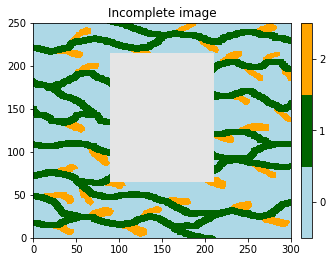

In [3]:
col = ['lightblue', 'darkgreen', 'orange']

plt.figure(figsize=(5,5))
imgplt.drawImage2D(im, categ=True, categCol=col, title='Incomplete image')

## Reconstruction of the image
Deesse can be used to reconstruct the missing part of the image, i.e. to simulate the variable in uninformed cells. For that, the same incomplete image is specified as the training image and as hard data set. In this situation, the image is called a training data set.

**Note:** of course, an incomplete training image can be used for simulation on a different simulation grid with or without hard data.

### Fill the input structure for deesse and launch deesse

In [4]:
nreal = 20
deesse_input = dsi.DeesseInput(
    nx=im.nx, ny=im.ny, nz=im.nz, # set same dimensions grid as for the incomplete image
    sx=im.sx, sy=im.sy, sz=im.sz, # set same cell units grid as for the incomplete image
    ox=im.ox, oy=im.oy, oz=im.oz, # set same origin grid as for the incomplete image
    nv=1, varname=im.varname,     # number of variable(s), name of the variable(s), as for the incomplete image
    nTI=1, TI=im,                 # set the incomplete image as TI
    dataImage=im,                 # set the incomplete image as hard data
    distanceType=0,
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = dsi.deesseRun(deesse_input)

********************************************************************************
DEESSE VERSION 3.0 / BUILD NUMBER 20190110
********************************************************************************
DONE


## Retrieve the reconstructed images (and display)

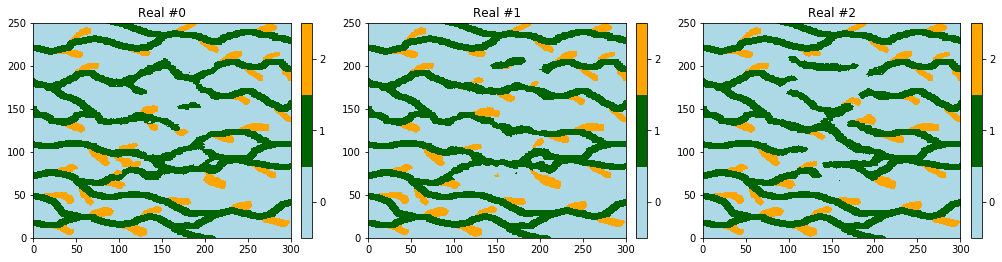

In [5]:
# Retrieve the results
sim = deesse_output['sim']

# Display
plt.subplots(1, 3, figsize=(17,5)) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    imgplt.drawImage2D(sim[i], categ=True, categCol=col, title='Real #{}'.format(i)) # plot real #i

## Do some statistics on the reconstructed images

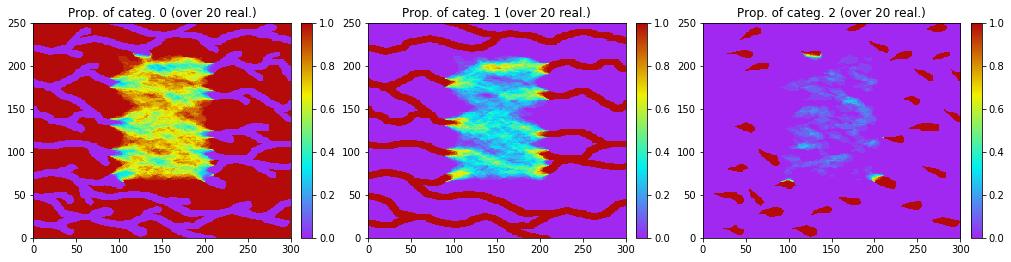

In [6]:
# Retrieve the realizations
sim = deesse_output['sim']

# Do some statistics on the realizations
# ... gather all the realizations into one image
all_sim = img.gatherImages(sim) # all_sim is one image with nreal variables
# ... compute the pixel-wise proportion for the given categories
all_sim_stats = img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(1, 3, figsize=(17,5)) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    imgplt.drawImage2D(all_sim_stats, iv=i, 
                       title='Prop. of categ. {} (over {} real.)'.format(i, nreal))

## Reconstruction using pyramids
Enabling pyramids implies multi-resolution simulations, which can help to better reproduce the spatial structures.

In [7]:
# Deesse input
#   - with 2 additional levels (npyramidLevel=2) 
#     and a reduction factor of 2 along x and y axes between the original image 
#     and the 1st pyramid level and between the 1st pyramid level to the second one 
#     (kx=[2, 2], ky=[2, 2], kz=[0, 0]: do not apply reduction along z axis)
pyrGenParams = dsi.PyramidGeneralParameters(npyramidLevel=2, kx=[2, 2], ky=[2, 2], kz=[0, 0])
pyrParams = dsi.PyramidParameters(nlevel=2, pyramidType='categorical_auto')

deesse_input = dsi.DeesseInput(
    nx=im.nx, ny=im.ny, nz=im.nz,
    sx=im.sx, sy=im.sy, sz=im.sz,
    ox=im.ox, oy=im.oy, oz=im.oz,
    nv=1, varname=im.varname,
    nTI=1, TI=im,
    dataImage=im,
    distanceType=0,
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams, # pyramid general parameters
    pyramidParameters=pyrParams,           # pyramid parameters for each variable
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
deesse_output = dsi.deesseRun(deesse_input)

********************************************************************************
DEESSE VERSION 3.0 / BUILD NUMBER 20190110
********************************************************************************
DONE


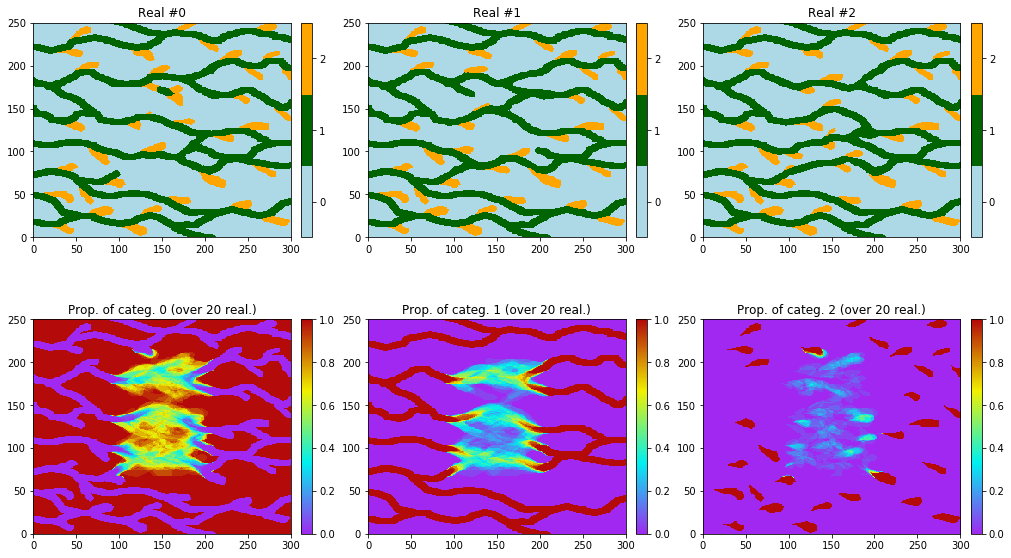

In [8]:
# Retrieve the realizations
sim = deesse_output['sim']

# Do some statistics on the realizations
# ... gather all the realizations into one image
all_sim = img.gatherImages(sim) # all_sim is one image with nreal variables
# ... compute the pixel-wise proportion for the given categories
all_sim_stats = img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(1, 3, figsize=(17,10)) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    imgplt.drawImage2D(sim[i], categ=True, categCol=col, title='Real #{}'.format(i)) # plot real #i

for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    imgplt.drawImage2D(all_sim_stats, iv=i, title='Prop. of categ. {} (over {} real.)'.format(i, nreal))